<a href="https://colab.research.google.com/github/Ashi743/pytorch/blob/main/ANN_HYPERPARAM_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import torch
from torch import nn
import pandas  as pd
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

#print("Path to dataset files:", path)

for filename in os.listdir(path):
  if filename.endswith('csv'):

    csv_filepath= os.path.join(path, filename)

    print(csv_filepath)

/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_train.csv
/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_test.csv


In [72]:
#check gpu
device= torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [73]:
train= pd.read_csv("/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_train.csv")
test = pd.read_csv("/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_test.csv")

In [74]:
#read_data
print(train.shape, test.shape)
print(train.label.unique() ,train.label.nunique())
train.head()

(60000, 785) (10000, 785)
[2 9 6 0 3 4 5 8 7 1] 10


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


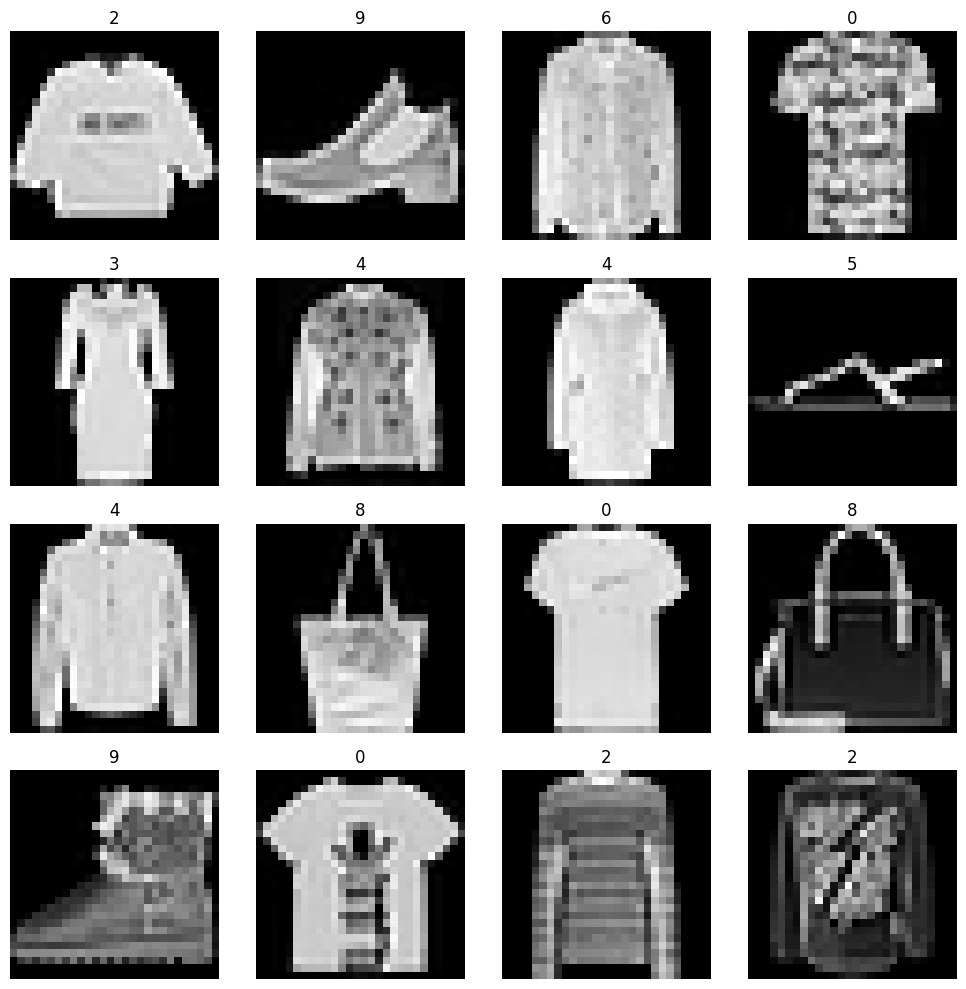

In [75]:
import matplotlib.pyplot as plt
fig, ax= plt.subplots(ncols=4, nrows= 4, figsize= (10,10))
for i, ax in enumerate(ax.flatten()):  #to flatten 4x4 into 0-15
  img= train.iloc[i, 1:].values.reshape(28,28)
  ax.imshow(img, cmap= 'grey')
  ax.axis('off')
  ax.set_title(train.iloc[i,0])
plt.tight_layout()
plt.show()

In [76]:
X_train= train.iloc[:, 1:].values   # to get values not the df
Y_train= train.iloc[:, 0 ].values

X_test= test.iloc[:, 1:].values   # to get values not the df
Y_test= test.iloc[:, 0 ].values

In [77]:
#scaling

X_train_scaled= X_train/255
X_test_scaled = X_test/255

In [78]:
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [79]:
#custom dataset
class customdataset(Dataset):
  def __init__(self, features, label):
    self.features= torch.tensor(features, dtype =torch.float32)
    self.label   = torch.tensor(label   , dtype =torch.long)
  def __len__(self):
    return len(self.features)
  def __getitem__(self, index):
    return self.features[index], self.label[index]

In [80]:
#dataset
train_dataset= customdataset(X_train_scaled, Y_train)
test_dataset = customdataset(X_test_scaled , Y_test)

In [81]:
train_dataset
len(train_dataset)

60000

**hyperparameter**

In [82]:
#model
class mymodelnn(nn.Module):
  def __init__(self, input_dim, output_dim ,num_hidden_layers, neurons_perlayer, dropout_rate):
    super().__init__()

    layers= [] #dynamic list to store layers and dropouts
    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim, neurons_perlayer))            #784, 128 initially
      #batch_norm
      layers.append(nn.BatchNorm1d(neurons_perlayer))
      #activation
      layers.append(nn.ReLU())
      #dropout
      layers.append(nn.Dropout(dropout_rate))
      input_dim= neurons_perlayer

    layers.append(nn.Linear(neurons_perlayer, output_dim))

    #model
    self.model = nn.Sequential(*layers)       #unpack of layers

  def forward(self, x):
    return self.model(x)

In [91]:
def objective(trial):
  #search space parameters
  num_hidden_layers= trial.suggest_int('num_hidden_layers' ,1,5)
  neurons_perlayer = trial.suggest_int('neurons_perlayer'  ,1,128, step= 8)

  epochs           = trial.suggest_int("epochs", 10,50, step=10)
  learning_rate    = trial.suggest_float("learning_rate", 1e-5, 1e-1 ,log= True)
  dropout_rate     = trial.suggest_float("dropout_rate", 0.1, 0.7 ,step= 0.1)
  batch_size       = trial.suggest_categorical("batch_size", [16,32,64,128])
  optimizer_name   = trial.suggest_categorical("optimizer_name", ['Adam' ,'SGD', 'RMSprop'])
  weight_decay     = trial.suggest_float("weight_decay", 1e-5, 1e-3 ,log= True)

  #create datalodaer
  train_dataloader= DataLoader(train_dataset, batch_size= batch_size, shuffle=True, pin_memory=True)
  test_dataloader = DataLoader(test_dataset , batch_size= batch_size, shuffle=False,pin_memory=True)   #prediction needs constant data

  #model init
  input_dim = 784
  output_dim= 10   #10 labels
  model= mymodelnn(input_dim, output_dim,num_hidden_layers, neurons_perlayer ,dropout_rate)
  #MOVE TO GPU
  model.to(device)

  #parameters init
                #learning_rate= 0.01
                #epochs= 50


  #optimizer init
  loss_= nn.CrossEntropyLoss()
            #optimizer= optim.SGD(model.parameters(), lr= 0.1, weight_decay= 1e-4)


  if optimizer_name=='Adam':
    optimizer= optim.Adam(      model.parameters(),     lr= learning_rate,    weight_decay= weight_decay)

  elif optimizer_name=='SGD':
    optimizer= optim.SGD(       model.parameters(),     lr= learning_rate,    weight_decay= weight_decay)

  else:
    optimizer= optim.RMSprop(   model.parameters(),     lr= learning_rate,    weight_decay= weight_decay)

  #train loop
  for epoch in range(epochs):
    total_epoch_loss= 0
    for batch_features, batch_labels in train_dataloader:
      #MOVE TO GPU
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
      output= model(batch_features)

      loss= loss_(output, batch_labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #total_epoch_loss= total_epoch_loss+loss.item()

    #avg_loss= total_epoch_loss/len(train_dataloader)
    #print(f'epoch: {epoch+1}, loss: {avg_loss}')

  #eval loop
  model.eval()
  total= 0
  correct= 0
  with torch.no_grad():
    for batch_features, batch_labels in test_dataloader:
      #MOVE TO GPU
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
      output= model(batch_features)

      _, predicted= torch.max(output, 1)
      total+=batch_labels.shape[0]
      correct+=(predicted == batch_labels).sum().item()
    accuracy = correct/total

  return accuracy

In [88]:
!pip install optuna

In [89]:
import optuna
import warnings
#warnings.filterwarnings('ignore')

In [92]:
#study
study= optuna.create_study(direction='maximize')
study.optimize(objective, n_trials= 50)

[I 2025-01-19 15:07:21,289] A new study created in memory with name: no-name-bdbb014f-f80f-4960-a8de-d0603d9d8b42
[I 2025-01-19 15:09:42,296] Trial 0 finished with value: 0.8327 and parameters: {'num_hidden_layers': 3, 'neurons_perlayer': 41, 'epochs': 40, 'learning_rate': 0.00025270243661029105, 'dropout_rate': 0.2, 'batch_size': 64, 'optimizer_name': 'SGD', 'weight_decay': 1.846896548965683e-05}. Best is trial 0 with value: 0.8327.
[I 2025-01-19 15:12:30,433] Trial 1 finished with value: 0.7429 and parameters: {'num_hidden_layers': 4, 'neurons_perlayer': 41, 'epochs': 40, 'learning_rate': 2.538177881327587e-05, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer_name': 'Adam', 'weight_decay': 1.316175714432329e-05}. Best is trial 0 with value: 0.8327.
[I 2025-01-19 15:13:29,550] Trial 2 finished with value: 0.8858 and parameters: {'num_hidden_layers': 1, 'neurons_perlayer': 121, 'epochs': 20, 'learning_rate': 0.00011356234217079464, 'dropout_rate': 0.4, 'batch_size': 64, 'optimizer_nam

In [93]:
study.best_value, study.best_params

(0.9045,
 {'num_hidden_layers': 3,
  'neurons_perlayer': 121,
  'epochs': 50,
  'learning_rate': 0.0002204656367006667,
  'dropout_rate': 0.1,
  'batch_size': 32,
  'optimizer_name': 'Adam',
  'weight_decay': 0.00017508314825707586})

In [94]:
from optuna.visualization import plot_parallel_coordinate
plot_parallel_coordinate(study).show()